# Analysis of the data

Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import operator
import itertools
import nltk
from tqdm import tqdm
import seaborn as sns
import random
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

GLOBAL VARIABLES

In [2]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath("__file__")), ".."))
DATA_DIR = os.path.join(ROOT_DIR, "data")
MAX_SYNOPSIS_LEN = 150

print(ROOT_DIR)
print(DATA_DIR)

/home/alejandro/Dropbox/Carpeta personal/Universidad - Master/2º Semestre/Natural Computing/films-synopsis-generator
/home/alejandro/Dropbox/Carpeta personal/Universidad - Master/2º Semestre/Natural Computing/films-synopsis-generator/data


Load the data

In [3]:
df = pd.read_csv(filepath_or_buffer  = os.path.join(DATA_DIR,'synopsis_genres.csv'),sep = '#',encoding = 'latin_1',index_col = 'ID')
df = df[df['Synopsis'].notnull() & df['Genre'].notnull()]
df.info()
print(str(df.head()).encode('latin1'))

<class 'pandas.core.frame.DataFrame'>
Index: 114451 entries, https://www.filmaffinity.com/es/film740563.html to https://www.filmaffinity.com/es/film469189.html
Data columns (total 2 columns):
Genre       114451 non-null object
Synopsis    114451 non-null object
dtypes: object(2)
memory usage: 2.6+ MB
b'                                                                                             Genre  \\\nID                                                                                                   \nhttps://www.filmaffinity.com/es/film740563.html                                            Comedia   \nhttps://www.filmaffinity.com/es/film275936.html  Infantil|Comedia|Animales|Perros/Lobos|Deporte...   \nhttps://www.filmaffinity.com/es/film697174.html                                      Drama|Secuela   \nhttps://www.filmaffinity.com/es/film775580.html                         Acci\xf3n|Aventuras|Espionaje   \nhttps://www.filmaffinity.com/es/film303582.html  Animaci\xf3n|Drama|Cortom

Total number of training points

In [4]:
caps = list(df['Synopsis'].map(lambda s : ' '.join(re.findall(r"[\w]+|[^\s\w]", s)).lower()).values)

total_samples=0
for text in caps:
    total_samples+=len(text.split())-1
print("Total samples : "+str(total_samples))

Total samples : 7751265


Check for the length of the sentences

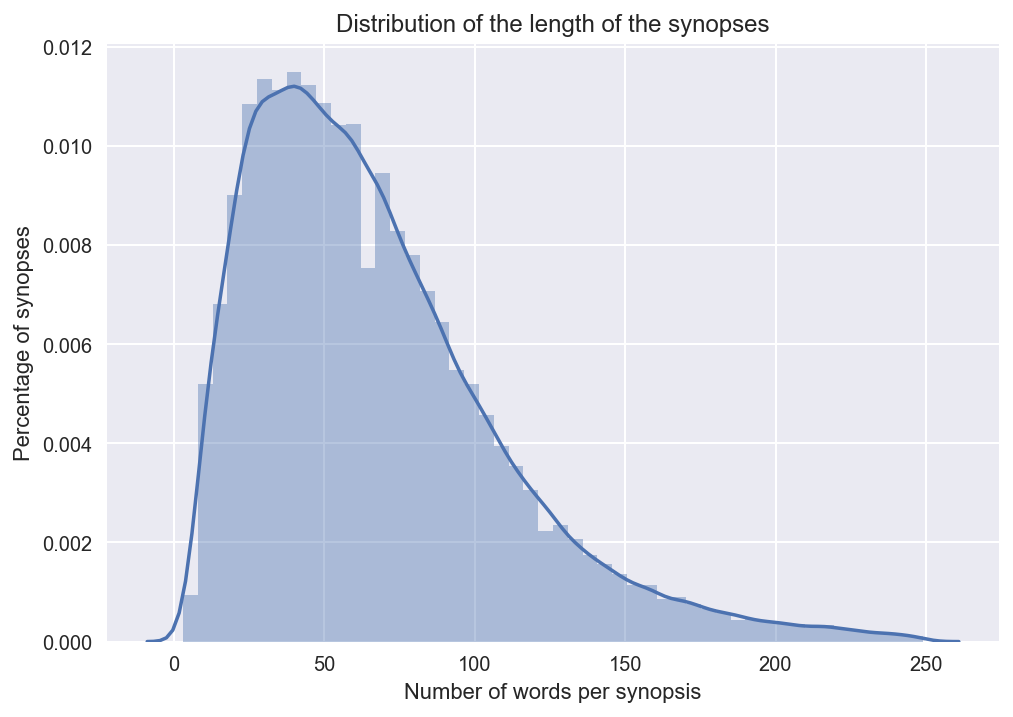

In [5]:

spl_by_word = [txt.split() for txt in caps]

lengths = [len(entry) for entry in spl_by_word if len(entry)<250]


# Graph option 1
x = np.array(lengths)
sns.set(color_codes=True)
plot = sns.distplot(x);
plot.set(xlabel='Number of words per synopsis', ylabel='Percentage of synopses', title="Distribution of the length of the synopses")
plt.show()

# Graph option 2
# num_bins = range(1, 1000)
#plt.hist(x,  bins=num_bins, rwidth=2)
#plt.title("Distribution of the length of the descriptions")
#plt.xlabel("Number of words")
#plt.ylabel("Number of descriptions")
#plt.xlim(0,1000)
#plt.show()

Show some long sentences

In [6]:
count = 0
for i, value in enumerate(x):
    if value > 200:
        print(caps[i]+'\n========================')
        count += 1
    if count >= 3:
        break

serie de tv ( 1989 - 1990 ) . 229 episodios . gustavo ochoa , un joven y existoso empresario dedicado a la confección de ropa , decide mudarse para vivir solo , y opta por comprar la casa en venta de la familia de fernanda . durante un tiempo , ella visita regularmente a gustavo , buscando correspondencia que llega a su nombre . entre ellos se va generando una relación afectuosa , muchas veces interrumpida por mimicha , que es la amante de gustavo y esposa del socio de su padre .
un hombre muere de viruela en el aeropuerto de londres y cunde el pánico , mientras las autoridades intentan localizar al portador .
el 12 de diciembre de 2012 , algunos de los nombres más emblemáticos del entretenimiento se reunieron en el madison square garden para un histórico concierto en beneficio de las víctimas del huracán sandy . 12 . 12 . 12 captura esa reunión sin precedentes .


Get some basic information about the text corpus we have

In [7]:
raw_words = []

for descrp in caps:
    raw_words.extend(descrp.split())

print("Total number of words: %d " % len(raw_words))
vocabulary = set(raw_words)
print("Size of vocabulary: %d " % len(vocabulary))


Total number of words: 7865716 
Size of vocabulary: 151852 


How about the frequency of our words

In [8]:
# Get all the words the occur only once for the given wordlist
desired_value = 3
myDict = dict(Counter(raw_words))
hapax_legomena = [k for k, v in myDict.items() if v <= desired_value]
print("Words that appear 3 times or less: %d " % len(hapax_legomena))
desired_value = 2
hapax_legomena = [k for k, v in myDict.items() if v <= desired_value]
print("Words that appear 2 times or less: %d " % len(hapax_legomena))
desired_value = 1
hapax_legomena = [k for k, v in myDict.items() if v <= desired_value]
print("Words that appear 1 times or less: %d " % len(hapax_legomena))

Words that appear 3 times or less: 100968 
Words that appear 2 times or less: 89855 
Words that appear 1 times or less: 68368 


Get a nice graph of this information

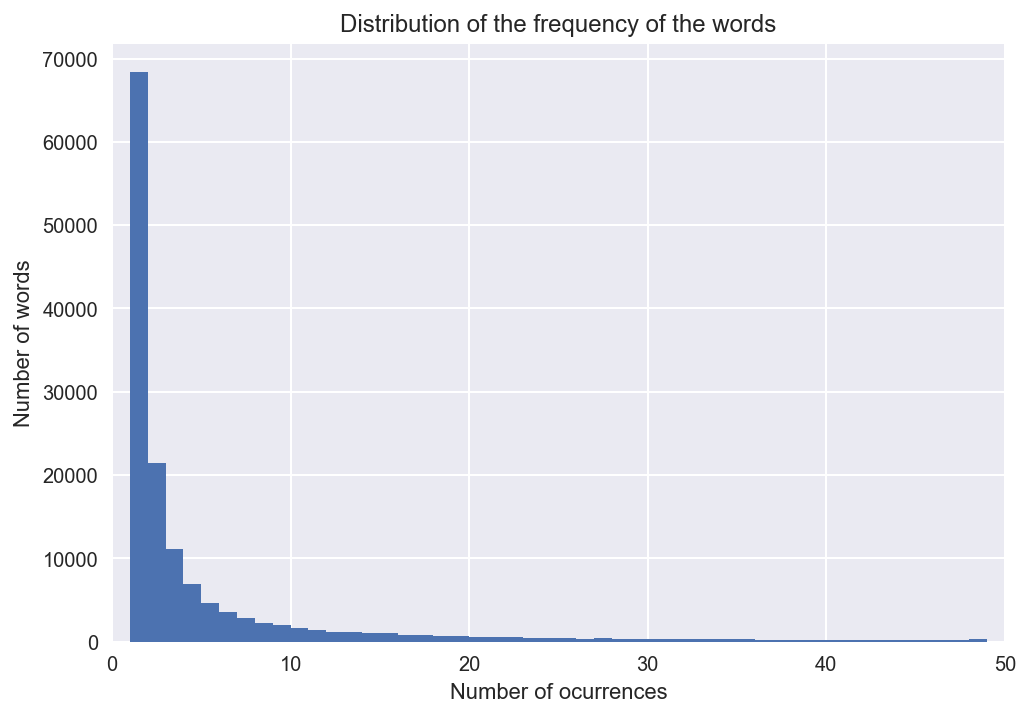

In [9]:
num_bins = range(1, 50)

x = np.asarray(list(myDict.values()))

plt.hist(x,  bins=num_bins, rwidth=2)
plt.title("Distribution of the frequency of the words")
plt.xlabel("Number of ocurrences")
plt.ylabel("Number of words")
plt.xlim(0,50)
plt.show()

Check some words according to their frequency

In [10]:
count = 0
for word, frec in myDict.items():
    if frec == 1:
        print(word+'\n========================')
        count += 1
        
    if count > 100:
        break

sillitoe
transmitirlo
tindario
ahorcarla
odeta
chulería
cloney
dantzig
bambuco
mesoamericana
anehara
suny
zefir
taiyô
sudden
yarno
exportacion
amarían
yeshiva
fastidiará
canaca
fowley
goodwill
reverencian
ciberinsectos
porra
1x36
mofó
flappy
4th
incendiando
lunalunera
beltham
lole
avistó
tinpis
koemtzis
kommissar
entresuelo
saviamarina
entrerriana
calarcá
narsimha
declinación
bockner
desvergüenzas
sakogami
sinikka
jomathas
santanda
jetstream
interepretados
cortessi
tensará
clasa
arjah
oblast
sandin
gebali
heera
guerilla
sangraba
segadora
postmodernos
sintonizan
médoc
gaeta
boseo
prusianas
orlandi
kopot
censoplano
temporera
canham
bipedalismo
serén
licuado
noortje
hedonistas
radex
extramares
ead
kasuminome
rubita
miralta
braiger
ilmari
enfrascamos
puzzling
candorosas
difíciil
fomrado
matondkar
decrecieron
launius
lanty
hungarian
sawtelle
intermesoli
empavorecida
maluquinho


Check how many words we would substitute for unknown tokens (or delete) if we are using the X most common words of the dataset

In [42]:
VOCAB_SIZE = 50000

freq_dist = nltk.FreqDist(raw_words)
# get vocabulary of 'vocab_size' most used words
vocab = freq_dist.most_common(VOCAB_SIZE)
vocab = [tup[0] for tup in vocab]

kept = 0

for word, frec in tqdm(myDict.items(),miniters=1000):
    if word in vocab:
        kept += frec

print("If we take the {} more common words, we are keeping the {} of the words"
      .format(VOCAB_SIZE, 1 - (len(raw_words) - deleted)/len(raw_words)))

100%|██████████| 151852/151852 [06:47<00:00, 372.97it/s]

If we take the 50000 more common words, we are keeping the 0.9811565787526526 of the words


Check basic information about the labels

In [11]:
mlb = MultiLabelBinarizer()


genres_features = mlb.fit_transform(df['Genre'].map(lambda x: x.split('|')))
print(len(mlb.classes_)," different genres found:",str(mlb.classes_).encode('latin1')[:100],"...")
print(genres_features.shape)


378  different genres found: b"['11-S' '3-D' 'Abusos sexuales' 'Acci\xf3n' 'Acoso escolar' 'Adolescencia'\n 'Adopci\xf3n' 'Ajedrez' 'Alcoh" ...
(114451, 378)


Check the distribution of the classes

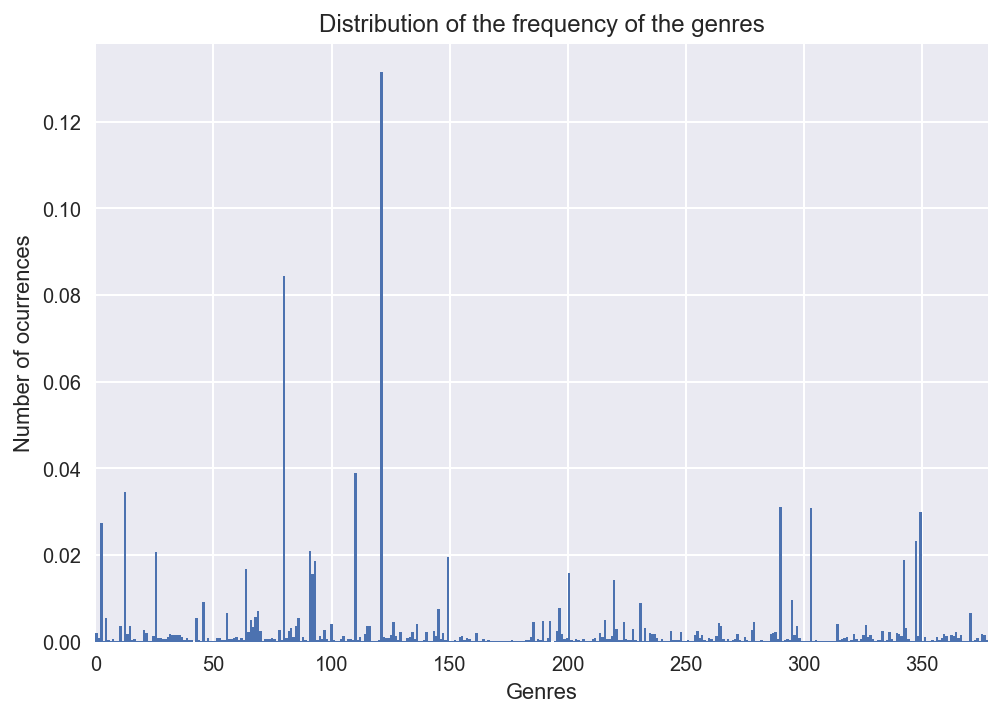

The 25 more common genre are (in descending order): ['Drama' 'Comedia' 'Documental' 'Animación' 'Romance' 'Serie de TV'
 'Thriller' 'Acción' 'Terror' 'Cortometraje' 'Aventuras' 'Fantástico'
 'Telefilm' 'Crimen' 'Ciencia ficción' 'Intriga' 'Cortometraje (animación)'
 'Mediometraje' 'Secuela' 'Biográfico' 'Musical' 'Infantil' 'Familia'
 'Cine mudo' 'Bélico']
At least one of these labels is in the 99.04937484163528% of the instances


In [23]:
genres_s = np.cumsum(genres_features, axis=0)[len(genres_features)-1,:]
genres_n = len(genres_features)

#plt.plot(np.sort(genres_s))
#plt.title("Distribution of the frequency of the genres")
#plt.xlabel("Genres")
#plt.ylabel("Number of ocurrences")
#plt.show()
bins = np.linspace(0, len(genres_s)+1, len(genres_s))
x = [random.gauss(3,1) for _ in range(400)]
#print(genres_s)
#print(x)
a = np.concatenate([i*np.ones(value) for i,value in enumerate(genres_s)])

plt.hist(a, bins = bins, rwidth=1,normed=True)
plt.title("Distribution of the frequency of the genres")
plt.xlabel("Genres")
plt.ylabel("Number of ocurrences")
plt.xlim(0,len(genres_s))
plt.show()


top = 25

most_common = np.sort(genres_s)[len(genres_s)-top:len(genres_s)][::-1]
genres_s = genres_s.tolist()
#indexes = genres_s.tolist().index(np.sort(genres_s)[len(genres_s)-25:len(genres_s)])
indexes = [genres_s.index(value) for value in most_common]
print("The {} more common genre are (in descending order): {}".format(len(indexes),mlb.classes_[indexes]))

count = 0
#df['Genre'].map(lambda x: x.split('|'))
for entry in df['Genre'].map(lambda x: x.split('|')):
    if np.any(np.in1d(mlb.classes_[indexes], entry)):
#    if any mlb.classes_[indexes] in entry:
        count += 1

#print(count)

print("At least one of these labels is in the {}% of the instances".format(count/len(df['Genre'])*100))


Co-occurence Matrices

In [ ]:
most_common_text = mlb.classes_[indexes]
most_common_index = indexes
most_common_value = most_common

tags = most_common_text


subset = []
sub_genres_features = genres_features[:,most_common_index]
#df['Genre'].map(lambda x: x.split('|'))
for i, entry in enumerate(df['Genre'].map(lambda x: x.split('|'))):
    if np.any(np.in1d(mlb.classes_[indexes], entry)):
        subset.append(sub_genres_features[i])

np_ground_truth = np.asarray(subset)

#print(np_ground_truth[:20])

# Co-occurence Matrices
com_ground_truth = np.zeros([len(tags)]*2)
for l, tag in enumerate(tags):
        for l2, tag2 in enumerate(tags):
            if np_ground_truth[:,l].sum()>0:
                com_ground_truth[l, l2] = np_ground_truth[:,l].dot(np_ground_truth[:,l2])/np_ground_truth[:,l].sum()
            else:
                com_ground_truth[l, l2] = 0

# Plotting
data=go.Heatmap(z=com_ground_truth, x=list(tags), y=list(tags))

#fig = tls.make_subplots(rows=2, cols=1, subplot_titles=('Co-occurrence matrix','Co-occurrence matrix (copy)'))
#fig.append_trace(data, 1, 1)

#py.iplot(fig)

layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    margin=go.Margin(
        l=100,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

fig = go.Figure(data=[data], layout=layout)


py.iplot(fig)
